<center><font size="6">SANTANDER BANK PRODUCT RECOMMENDATION AND PREDICTION </font></center>

# Import packages

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

from surprise import KNNBasic, Dataset, accuracy, SVD, Reader
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson

# Project Background

Santander, like many other financial institutions, offers a wide range of financial products and services to its customers. However, it can be challenging for customers to navigate the complexity of the product portfolio and find the products that are best suited to their needs. To address this problem, Santander needs to develop a recommendation system for new products that can help customers discover and purchase the products that are most relevant to them.

Developing a recommendation system for new products is an important step for Santander to better serve its customers and improve its product portfolio. By addressing the challenges of sparse data, class imbalance, customer segmentation. Santander can develop an effective system that helps customers discover and purchase the products that are most relevant to them. This will lead to increased customer satisfaction and loyalty, as well as improved revenue business performance for Santander.

# Data Cleaning

<font size="6" color="red">PS: It may take **4-6 minutes** to run the dataset!!! </font> <br>
<font size="5">Because the Github only allows 1 GB for the git Large File Storage, but our actual dataset is 1.16GB. Therefore, the result may a little different in the presentation we showed.</font>

In [2]:
data = pd.read_csv('https://media.githubusercontent.com/media/JolinXiang/Machine-Learning/main/product.csv',
                   header=0,chunksize=1e6)
data = pd.concat([chunk for chunk in data])

/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/2778781819.py:3: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([chunk for chunk in data])
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/2778781819.py:3: DtypeWarning: Columns (5,8,10,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([chunk for chunk in data])
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/2778781819.py:3: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([chunk for chunk in data])
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/2778781819.py:3: DtypeWarning: Columns (11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.concat([chunk for chunk in data])
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/27787

In [3]:
data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-08-28,717199,N,ES,V,60,2007-09-07,0.0,67,1.0,...,0,0,0,0,1,0,0,1.0,1.0,1
1,2016-02-28,931292,N,ES,H,24,2011-08-09,0.0,54,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2016-01-28,1007618,N,ES,V,39,2012-03-05,0.0,46,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-10-28,1305809,N,ES,H,39,2014-09-11,0.0,13,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-11-28,1498174,N,ES,H,20,2015-11-04,1.0,0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [4]:
cols = ['fetch_date', 'cust_code', 'emp_index', 'country', 'sex', 'age', 'cust_date', 'new_cust', 'cust_seniority',
'indrel', 'last_date_as_primary', 'cust_type', 'cust_rel', 'residence_index', 'foreigner_index', 'spouse_index',
'joining_channel', 'deceased', 'address_type', 'prov_code','prov_name', 'activity_index', 'income', 'segmentation', 
'savings_account', 'guarentees', 'current_account', 'derivative_account', 'payroll_account', 'junior_account', 'mas_account',
'perticular_account', 'perticular_plus', 'st_deposit', 'mt_deposits', 'lt_deposits', 'e_account', 'funds', 'mortgage',
 'pension', 'loan', 'tax', 'credit_card', 'securities', 'home_account', 'payroll', 'pension2', 'direct_debit'
]

In [5]:
# change the column name
data.columns = cols

In [6]:
# we delete the columns which has null value larger than 90% 
data = data.loc[:,data.isnull().mean()<=0.9].dropna()

In [7]:
data.head()

,fetch_date,cust_code,emp_index,country,sex,age,cust_date,new_cust,cust_seniority,indrel,...,mortgage,pension,loan,tax,credit_card,securities,home_account,payroll,pension2,direct_debit
0,2015-08-28,717199,N,ES,V,60,2007-09-07,0.0,67,1.0,...,0,0,0,0,1,0,0,1.0,1.0,1
1,2016-02-28,931292,N,ES,H,24,2011-08-09,0.0,54,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-10-28,1305809,N,ES,H,39,2014-09-11,0.0,13,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
5,2015-12-28,520972,N,ES,V,79,2005-03-03,0.0,130,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
6,2015-02-28,271365,N,ES,V,41,2001-09-10,0.0,166,1.0,...,0,0,0,1,0,0,0,0.0,0.0,1


In [8]:
# convert datatype
data['cust_seniority'] = data['cust_seniority'].astype('int')
data['activity_index'] = data['activity_index'].astype('int')
data['age'] = data['age'].astype('int')

# Data Visualization

## Customers' Age Distribution

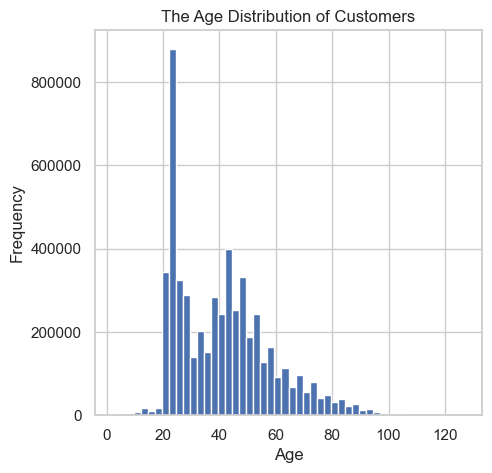

In [9]:
## Check the age distribution
plt.figure(figsize = (5,5))
data['age'].hist(bins=50)
plt.title("The Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Frequency");

**Observation:**
* As it is shown in the histgram, the range of our customers is quite wide, from the young to the old. Though the age of our customers have a large variance, we can still tell our main two large customer groups. One group is the people at university age, the other is people who are around middle age.   

## Old & New Customers

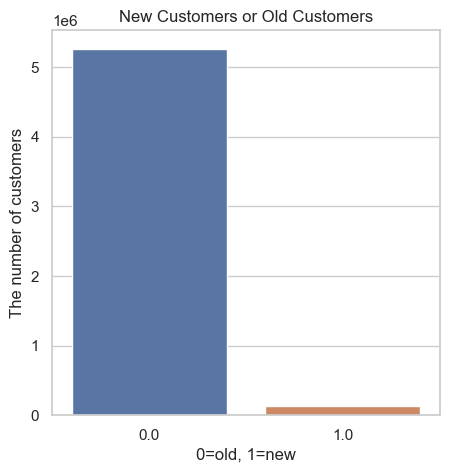

In [10]:
## Check how many customers are new
plt.figure(figsize = (5,5))
sns.countplot(x=data['new_cust'])
plt.title("New Customers or Old Customers")
plt.xlabel("0=old, 1=new")
plt.ylabel("The number of customers");

In [11]:
## Check percentage of new registered customers
data['new_cust'].value_counts()

0.0    5267376
1.0     129062
Name: new_cust, dtype: int64

**Observation:**
* Most of customers have a more than 6-month long accounts. New customers who register the account within 6 months only occupy about 2.5% in total.

## Joining Channels Distribution

In [12]:
## Only check the first 5
data['joining_channel'].value_counts().sort_values(ascending = False).head(8)

KHE    1653562
KAT    1376739
KFC    1289698
KFA     179271
KHQ     120630
KHK      96403
KHD      48218
KAS      37903
Name: joining_channel, dtype: int64

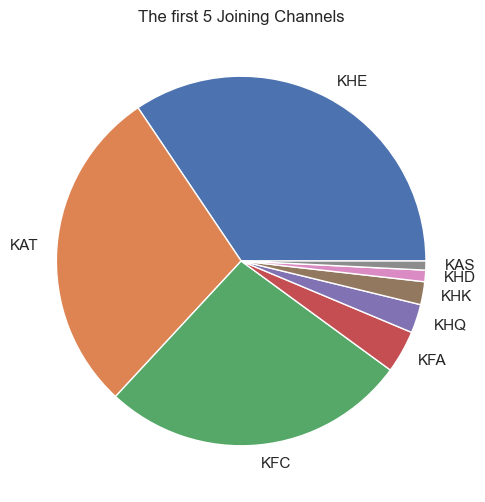

In [13]:
## Check the canal(canal_entrada)
plt.figure(figsize = (6,6))
y = np.array([1653562, 1376739, 1289698, 179271, 120630, 96403, 48218, 37903])
plt.pie(y, labels = ['KHE', 'KAT', 'KFC', 'KFA', 'KHQ', 'KHK', 'KHD', 'KAS'])
plt.title("The first 5 Joining Channels")
plt.show()

**Observation:**
* Though there are about more than 150 different joining canals, "KAT", "KFC" and "KHE" are our main customer joining sources.

## Customer Segmentations

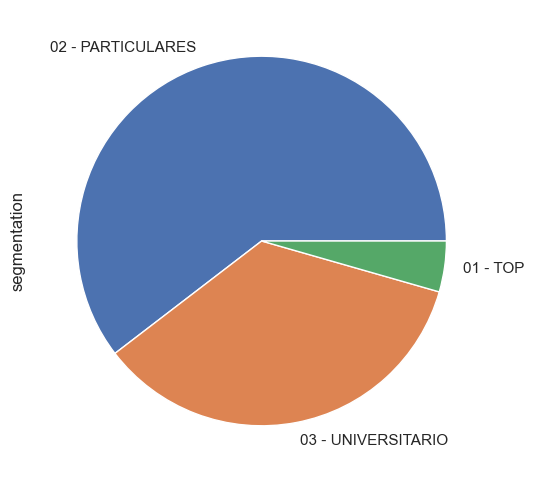

In [14]:
## Customer Segmental(segmento)
plt.figure(figsize = (6,6))
data['segmentation'].value_counts().plot(x=None, y=None, kind='pie');

**Observation:**
* As it is shown in the age distribution, the customer segmentation shows that Individuals and College Graduated accounts are main segmantations. 

## Income and Total number of accounts

In [15]:
## Create an income group and total_accounts
data_a = (data.groupby(pd.cut(data['income'], [0,60000,120000,180000,240000, pd.np.inf], right=False)).sum())
data['total_accounts'] = data.loc[:, 'savings_account':'direct_debit'].sum(axis=1)
data['total_accounts'] = data['total_accounts'].astype(int)

/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/4140161575.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data_a = (data.groupby(pd.cut(data['income'], [0,60000,120000,180000,240000, pd.np.inf], right=False)).sum())
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/4140161575.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_a = (data.groupby(pd.cut(data['income'], [0,60000,120000,180000,240000, pd.np.inf], right=False)).sum())


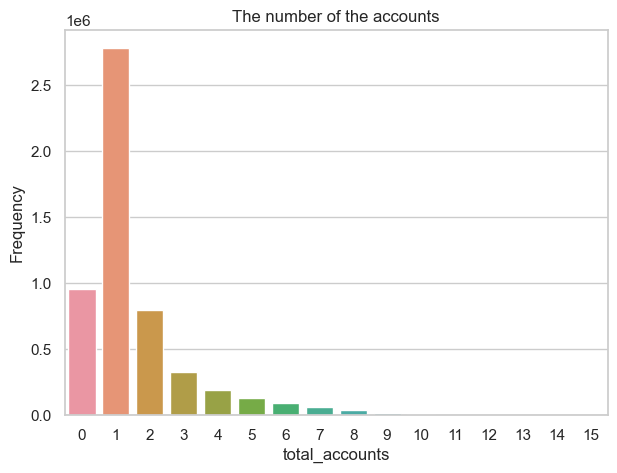

In [16]:
plt.figure(figsize = (7,5))
sns.countplot(x=data['total_accounts'])
plt.title("The Distribution of the Number of Total Accounts")
plt.title("The number of the accounts")
plt.ylabel("Frequency");

**Observation:**
* Most of customers have more than 1 accounts, but rarely use more than 5 accounts.

In [17]:
## Transposed the data_a
data_a = data_a.loc[:, "savings_account": "direct_debit"]
data_a = data_a.T

In [18]:
data_a.head(10)

income,"[0.0, 60000.0)","[60000.0, 120000.0)","[120000.0, 180000.0)","[180000.0, 240000.0)","[240000.0, inf)"
savings_account,57.0,128.0,174.0,142.0,126.0
guarentees,1.0,35.0,37.0,49.0,34.0
current_account,673639.0,1543041.0,710743.0,305917.0,309318.0
derivative_account,312.0,727.0,589.0,341.0,311.0
payroll_account,64337.0,188770.0,115561.0,55322.0,52346.0
junior_account,4777.0,19694.0,16162.0,8121.0,7035.0
mas_account,6731.0,20681.0,11821.0,5723.0,5034.0
perticular_account,81990.0,278314.0,189916.0,96936.0,100623.0
perticular_plus,24997.0,95896.0,65119.0,33686.0,34405.0
st_deposit,1303.0,3875.0,2186.0,870.0,688.0


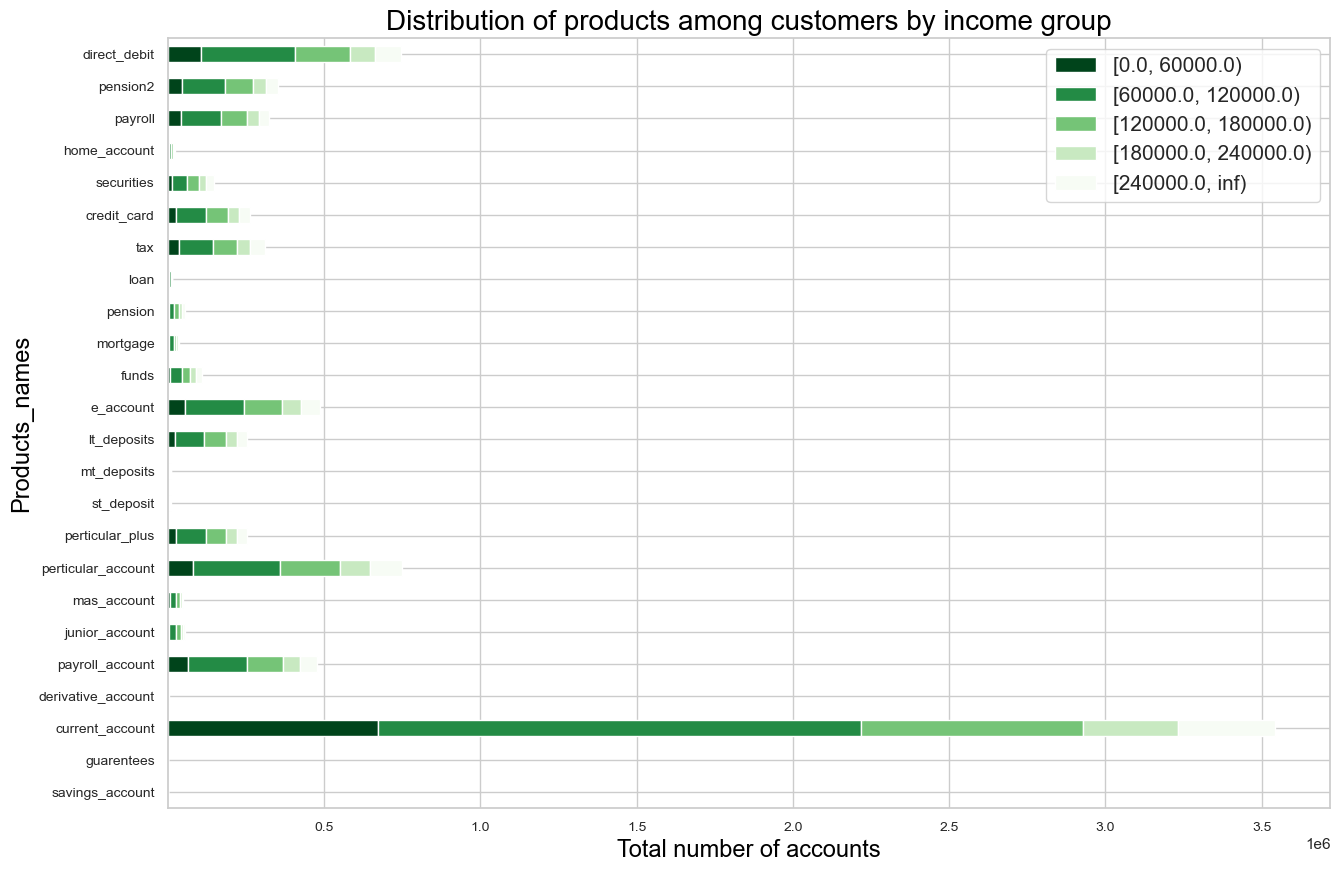

In [19]:
# Number of accounts by income 
data_a.plot(kind='barh', stacked=True, fontsize=10, figsize=[15,10], colormap='Greens_r')
plt.title('Distribution of products among customers by income group', fontsize=20, color='black') 
plt.xlabel('Total number of accounts', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) ;

In [20]:
## Drop the Current_account to see the distribution in other types of accounts
ex = ['current_account']
data_a = data_a.T
data_a = data_a.drop(ex, axis = 1).T

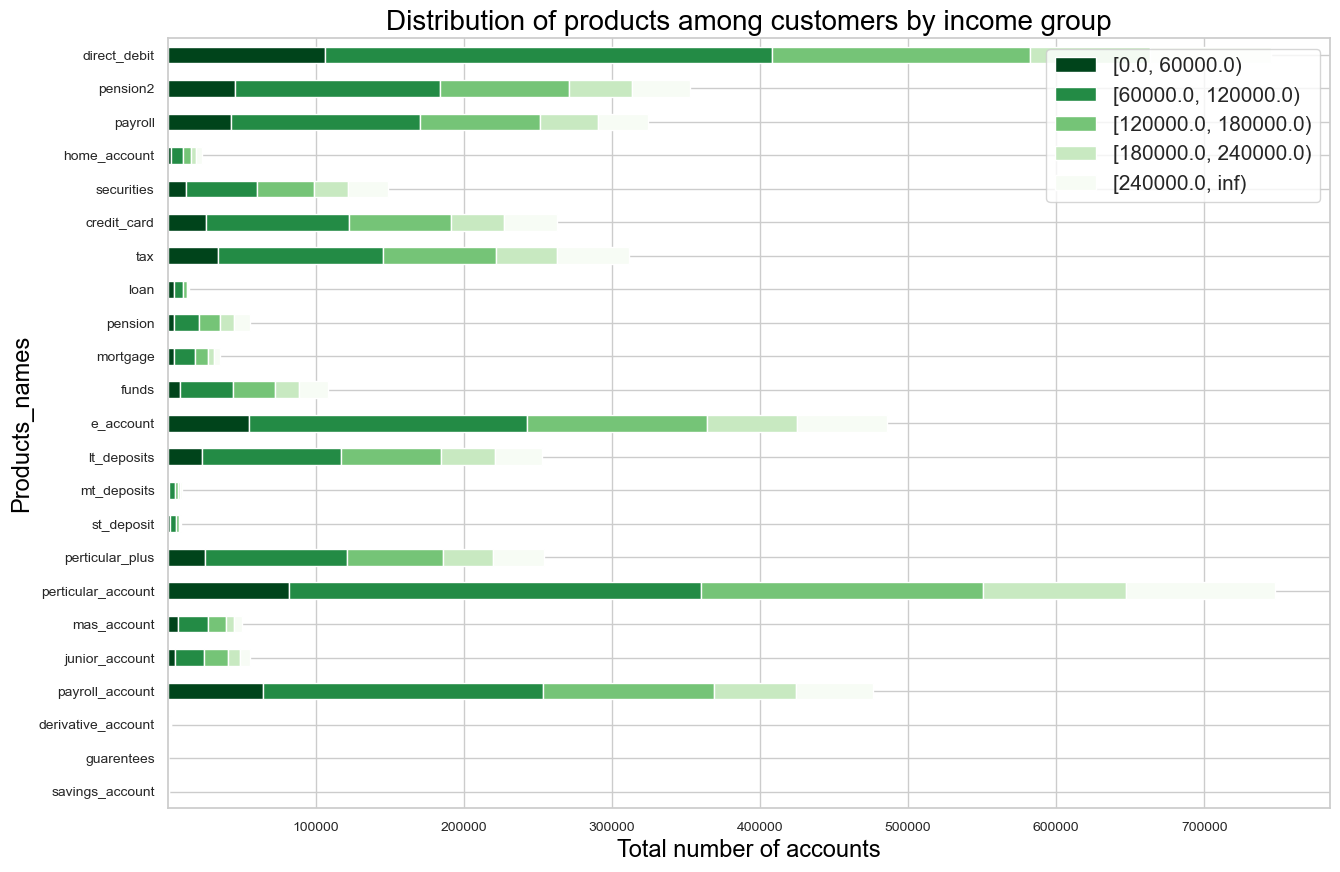

In [21]:
data_a.plot(kind='barh', stacked=True, fontsize=10, figsize=[15,10], colormap='Greens_r')
plt.title('Distribution of products among customers by income group', fontsize=20, color='black') 
plt.xlabel('Total number of accounts', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1) ;

**Observation:**
* After removing the current account, we can see that "direct_debit", "perticular_account", "e_account" and "payroll_account" are the most popular account products for customers whose incomes are from 60000 to 1800000.

## Age and Total numbers of accounts

In [22]:
data_b = data.groupby(['age'])['total_accounts'].agg('sum')

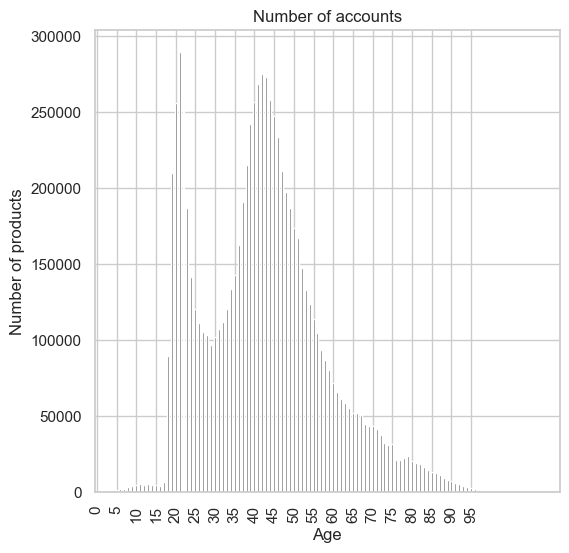

In [23]:
plt.figure(figsize = (6, 6))
data_b.plot(kind='bar', colormap = 'Accent_r', legend=None) 
plt.xticks(np.arange(0, 100, 5), [str(x) for x in np.arange(0, 100, 5)])
plt.title('Number of accounts') 
plt.xlabel('Age') 
plt.ylabel('Number of products');

In [24]:
data_b = (data.groupby(pd.cut(data['age'], [0,20,40,60,80,100, pd.np.inf], right=False)).sum())

/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/611389934.py:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  data_b = (data.groupby(pd.cut(data['age'], [0,20,40,60,80,100, pd.np.inf], right=False)).sum())
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/611389934.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_b = (data.groupby(pd.cut(data['age'], [0,20,40,60,80,100, pd.np.inf], right=False)).sum())


In [25]:
data_b = data_b.loc[:, "savings_account": "direct_debit"]
data_b = data_b.T

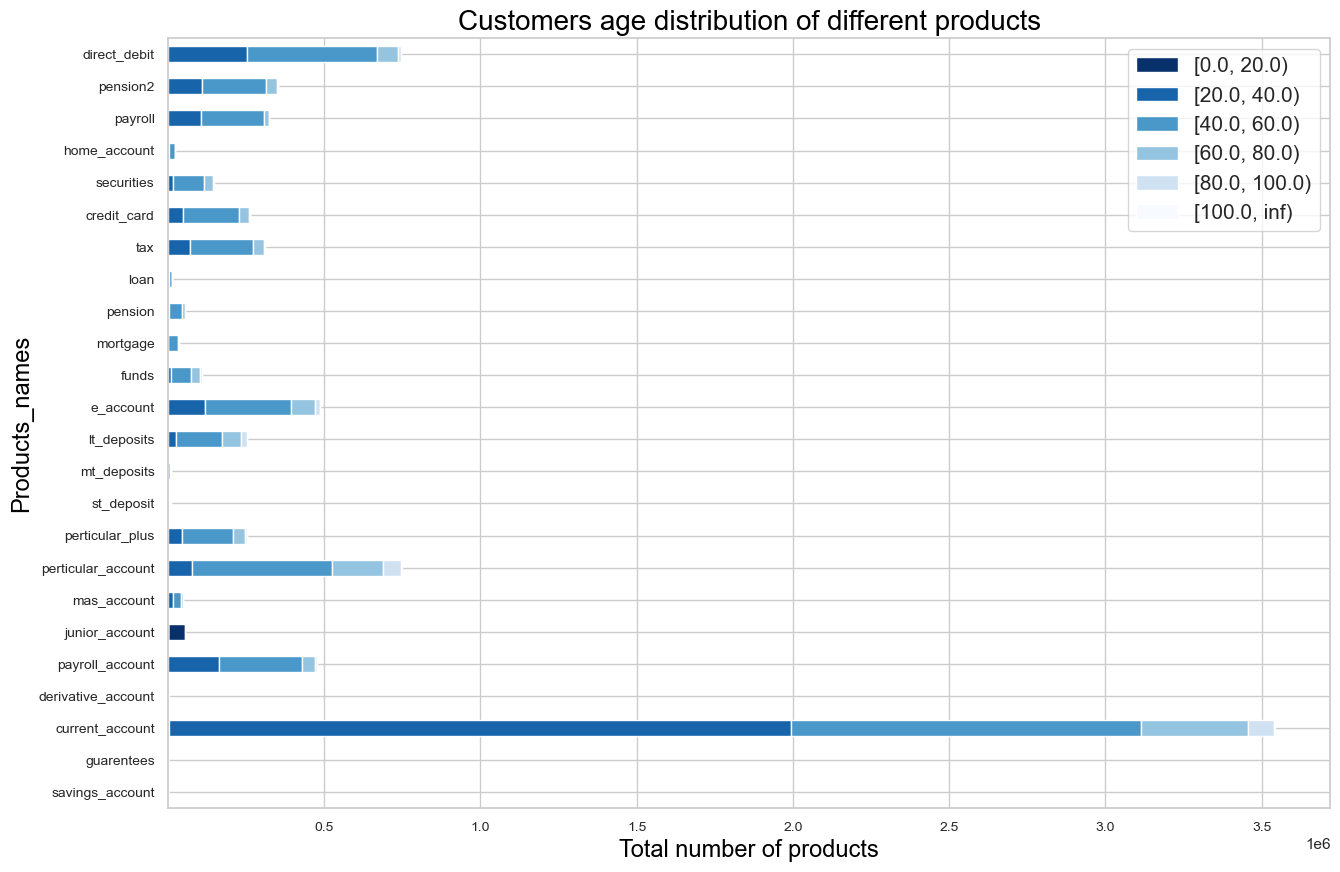

In [26]:
## Take a look at if age will affect the preference of account type
## Here we plot the customers' age distibution of each product 
data_b.plot(kind='barh', stacked=True, fontsize=10, figsize=[15,10], colormap='Blues_r')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc=1);

In [27]:
## Drop the Current_account to see the distribution in other types of accounts
ex = ['current_account']
data_b = data_b.T
data_b = data_b.drop(ex, axis = 1).T

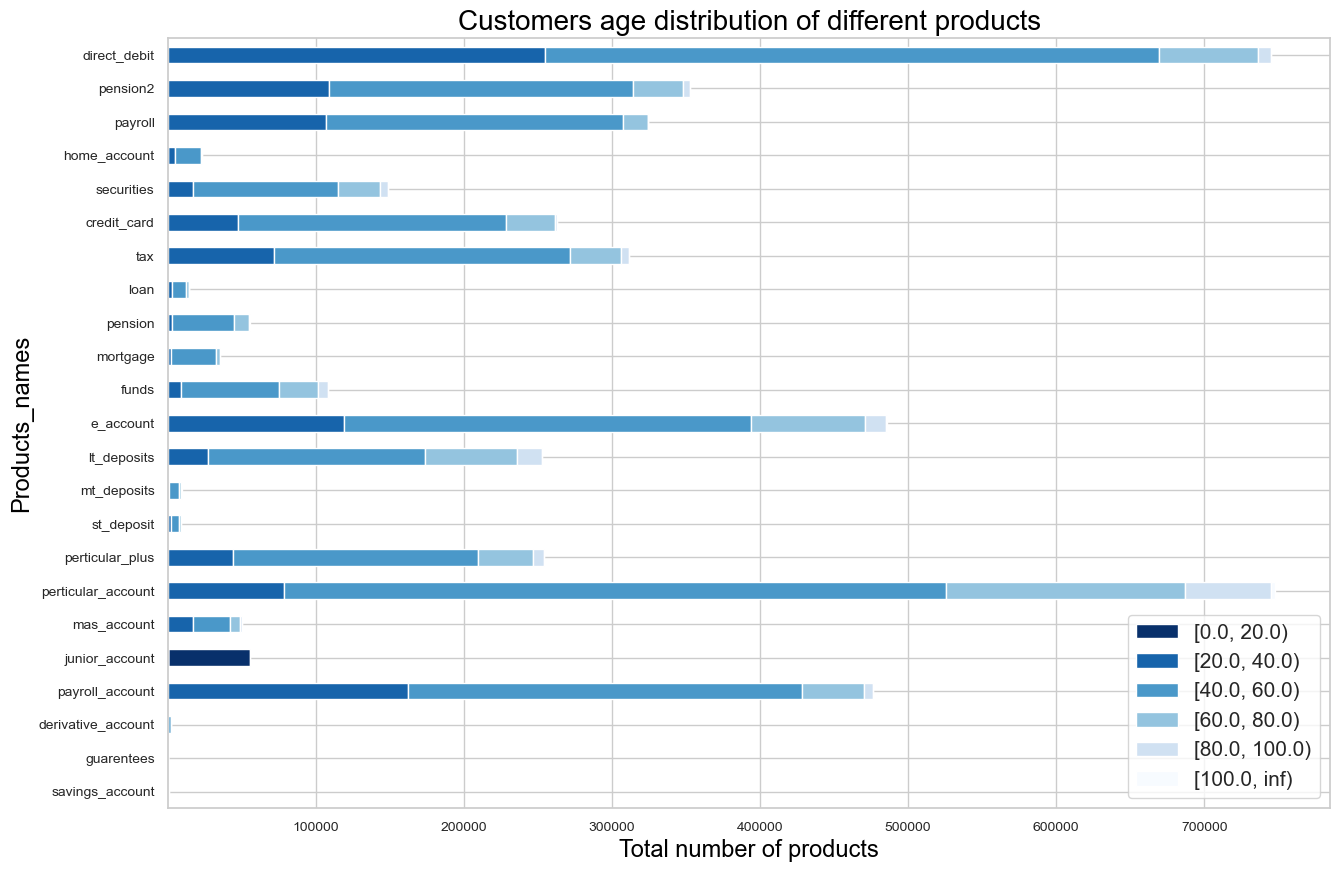

In [28]:
data_b.plot(kind='barh', stacked=True, fontsize=10, figsize=[15,10], colormap='Blues_r')
plt.title('Customers age distribution of different products', fontsize=20, color='black') 
plt.xlabel('Total number of products', fontsize=17, color='black') 
plt.ylabel('Products_names', fontsize=17, color='black') 
plt.legend(prop={'size':15}, loc='best');

**Observation:**
* After removing the current account, we can see that "direct_debit", "perticular_account", "e_account" and "payroll_account" are the most popular account products for customers both in the university age and in the middle age.

# Recommendation: Collaborative filter Model

Here we will use item-based KNN, user-based KNN and SVD to build our recommendation system. To use these model, we need 3 things : user_id, item_id, rating. So first we need to convert the product dataframe to the rating dataframe.

## Label Encoder

In [29]:
data = data.drop(columns='total_accounts')

In [30]:
# Define label encoder object, used to encode the subtyped eigenvalues
label = LabelEncoder()

# Convert one-hot encoded vectors to a single column
raw_target = data.iloc[:, 22:].idxmax(axis=1)

# Fit and transform the labels
transformed_target = label.fit_transform(raw_target)

# Add transformed column to our dataframe
data['option'] = transformed_target.astype('uint8')

data.head(10)

,fetch_date,cust_code,emp_index,country,sex,age,cust_date,new_cust,cust_seniority,indrel,...,pension,loan,tax,credit_card,securities,home_account,payroll,pension2,direct_debit,option
0,2015-08-28,717199,N,ES,V,60,2007-09-07,0.0,67,1.0,...,0,0,0,1,0,0,1.0,1.0,1,1
1,2016-02-28,931292,N,ES,H,24,2011-08-09,0.0,54,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
3,2015-10-28,1305809,N,ES,H,39,2014-09-11,0.0,13,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
5,2015-12-28,520972,N,ES,V,79,2005-03-03,0.0,130,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1
6,2015-02-28,271365,N,ES,V,41,2001-09-10,0.0,166,1.0,...,0,0,1,0,0,0,0.0,0.0,1,1
9,2015-09-28,301155,N,ES,V,60,2001-11-26,0.0,166,1.0,...,0,0,0,0,0,0,0.0,0.0,0,15
10,2015-04-28,194398,N,ES,V,60,2000-09-26,0.0,178,1.0,...,0,0,0,0,0,0,0.0,0.0,0,18
12,2016-04-28,635092,N,ES,H,39,2006-08-18,0.0,116,1.0,...,0,0,0,0,0,0,0.0,0.0,0,20
13,2016-03-28,742105,N,ES,H,67,2008-01-28,0.0,98,1.0,...,0,1,1,0,0,0,0.0,0.0,0,9
14,2015-11-28,1381977,N,ES,V,48,2015-02-11,0.0,9,1.0,...,0,0,0,0,0,0,0.0,0.0,0,1


In [31]:
# Creating a user-item matrix, each entry indicates the number of times service opted by that user
matrix = pd.crosstab(index=data.cust_code, columns=label.transform(raw_target), 
                               values=1, aggfunc='sum')
matrix.fillna(0, inplace=True)

In [32]:
matrix

col_0,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cust_code,,,,,,,,,,,,,,,,,,,,,
15889,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15892,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15893,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0
15894,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454615,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1454616,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1454617,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Convert the user_item_matrix to array datatype
user_arr = np.array(matrix)

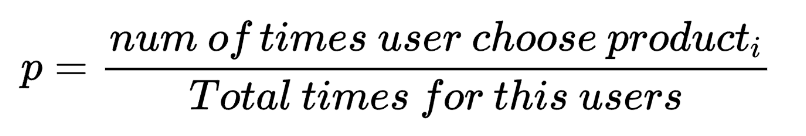

In [34]:
# Iterate through each row (user)
for row in range(len(user_arr)):
    # Calculate the sum of items for the current user
    user_sum = sum(user_arr[row])
    
    # Iterate through each item in the row
    for column in range(len(user_arr[row])):
        # Calculate the ratio of the current item to the user_sum
        ratio = user_arr[row][column] / user_sum
        
        # Update the uim_arr with the calculated ratio
        user_arr[row][column] = ratio
        
# Convert the array to dataframe for better view
ratio_matrix = pd.DataFrame(user_arr, columns=matrix.columns, index=matrix.index)

ratio_matrix

col_0,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cust_code,,,,,,,,,,,,,,,,,,,,,
15889,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
15890,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
15892,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
15893,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.714286,0.0,0.0
15894,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454615,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.666667,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1454616,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1454617,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [35]:
# Create the dataframe for user_id: cust_code, product_id:item_id and ratio:rating
user_item_ratio = pd.DataFrame({
    'cust_code': ratio_matrix.index.repeat(ratio_matrix.shape[1]),
    'product_id': list(ratio_matrix.columns) * ratio_matrix.shape[0],
    'ratio': ratio_matrix.values.ravel()
})

In [36]:
user_item_ratio

,cust_code,product_id,ratio
0,15889,0,0.0
1,15889,1,1.0
2,15889,2,0.0
3,15889,3,0.0
4,15889,4,0.0
...,...,...,...
16971019,1454620,19,0.0
16971020,1454620,20,0.0
16971021,1454620,21,0.0
16971022,1454620,22,0.0


In [37]:
# Remove rows where ratio is 0 (user never choose this product)
user_item_ratio = user_item_ratio[user_item_ratio['ratio'] != 0]

# Reset the index
user_item_ratio = user_item_ratio.reset_index(drop=True)

# Display the final dataframe
user_item_ratio

,cust_code,product_id,ratio
0,15889,1,1.000000
1,15890,15,1.000000
2,15892,1,0.750000
3,15892,15,0.250000
4,15893,10,0.285714
...,...,...,...
779429,1454615,15,0.666667
779430,1454616,1,1.000000
779431,1454617,1,1.000000
779432,1454618,20,1.000000


## Split train and test data set

Because our dataset is too big and our computer memory cannot support us to run the whole dataset so we only use 2.5% to do the item-based KNN and user-based KNN, and will use the whole dataset to do the SVD model.

In [38]:
df_half = user_item_ratio.sample(frac=0.025)

In [39]:
# Split data in training and test
train_data, test_data = train_test_split(df_half, test_size = 0.2)
print("Train size:", train_data.shape)    
print("Test size:", test_data.shape)      

Train size: (15588, 3)
Test size: (3898, 3)


In [40]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (0, 1))
data_train = Dataset.load_from_df(train_data[['cust_code', 'product_id', 'ratio']], reader)
data_test = Dataset.load_from_df(test_data[['cust_code', 'product_id', 'ratio']], reader)

In [41]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [42]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

## item-based KNN

In [43]:
sim_pearson = {'name':'pearson',
               'user_based':False
              }

basic_pearson = knns.KNNBasic(sim_options=sim_pearson,k=2)
basic_pearson.fit(data_train)

predictions = basic_pearson.test(data_testset)
user_basedKNN = accuracy.rmse(predictions)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2315
RMSE: 0.2315
0.231543203338979


The RSME is small and looks good.

In [44]:
def get_recommendation(uid, model):
    sid_list = range(24)
    pred_list = [model.predict(uid, sid).est for sid in sid_list]
    # Convert to pandas dataframe
    recommendations = pd.DataFrame({'uid': uid, 'sid': sid_list, 'pred': pred_list})
    # Sort by pred
    recommendations = recommendations.sort_values(by='pred', ascending=False).reset_index(drop=True)
    # Return
    return recommendations.head(5)

In [45]:
get_recommendation(1454617,basic_pearson)

,uid,sid,pred
0,1454617,0,0.905536
1,1454617,1,0.905536
2,1454617,22,0.905536
3,1454617,21,0.905536
4,1454617,20,0.905536


## user-based KNN

In [46]:
sim_pearson = {'name':'pearson',
               'user_based':True}

basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(data_train)

predictions = basic_pearson.test(data_testset)
user_basedKNN = accuracy.rmse(predictions)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2312
RMSE: 0.2312
0.2312318953894755


The RSME is small and looks good.

In [47]:
def get_recommendation(uid, model):
    sid_list = range(24)
    pred_list = [model.predict(uid, sid).est for sid in sid_list]
    # Convert to pandas dataframe
    recommendations = pd.DataFrame({'uid': uid, 'sid': sid_list, 'pred': pred_list})
    # Sort by pred
    recommendations = recommendations.sort_values(by='pred', ascending=False).reset_index(drop=True)
    # Return
    return recommendations.head(5)

In [48]:
get_recommendation(15890,basic_pearson)

,uid,sid,pred
0,15890,0,0.905536
1,15890,1,0.905536
2,15890,22,0.905536
3,15890,21,0.905536
4,15890,20,0.905536


**Conclusion:**
* The item-based KNN and user-based KNN do not perform well in our data. Because our data resulted in a sparse matrix. A sparse matrix refers to a matrix in which most of the elements are 0. In this case, many similarities between items or users cannot be calculated, making it difficult to provide effective recommendations to users. So the next part we will try to use SVD model.

## SVD

We use the whole dataset to do the SVD model. SVD algorithm uses the global information of matrix, it can better solve the problem of data sparsity. As it provide accurate and robust recommendations. 

In [49]:
# Split data in training and test
train_data, test_data = train_test_split(user_item_ratio, test_size = 0.2)
print("Train size:", train_data.shape)    # 80.00%
print("Test size:", test_data.shape)      # 20.00%

Train size: (623547, 3)
Test size: (155887, 3)


In [50]:
# Read the data into a Surprise dataset
reader = Reader(rating_scale = (0, 1))
data_train = Dataset.load_from_df(train_data, reader)
data_test = Dataset.load_from_df(test_data, reader)

In [51]:
# Build full trainset
data_train = data_train.build_full_trainset()
data_test = data_test.build_full_trainset()

In [52]:
# Create the trainset and testset
data_trainset = data_train.build_testset()
data_testset = data_test.build_testset()

In [53]:
# Create SVD algorithm with 5 factors
k_factors = 5
algo = SVD(n_factors= k_factors, n_epochs= 200, lr_all= 0.005, 
           reg_all= 0, init_mean= 0, init_std_dev= 0.01)

In [54]:
# Train the algorithm on the trainset
algo.fit(data_train)

In [55]:
# Calculate RMSE for training dataset
train_pred = algo.test(data_trainset)
accuracy.rmse(train_pred)

RMSE: 0.0181


0.01805122597705749

In [56]:
# Calculate RMSE for test dataset
test_pred = algo.test(data_testset)
accuracy.rmse(test_pred)

RMSE: 0.1913


0.19131094372186713

In [57]:
# Convert to the Dataframe 
test = pd.DataFrame(train_pred)
test = test.rename(columns={'uid':'userId', 'iid': 'itemId', 
                            'r_ui':'actual', 'est':'prediction'})
cf_model = test.pivot_table(index='userId', 
                            columns='itemId', values='prediction').fillna(0)

In [58]:
test.sort_values('userId').head(10)

,userId,itemId,actual,prediction,details
235632,15892,15,0.250000,0.322862,{'was_impossible': False}
235631,15892,1,0.750000,0.775102,{'was_impossible': False}
421045,15893,21,0.714286,0.718796,{'was_impossible': False}
421044,15893,10,0.285714,0.309514,{'was_impossible': False}
362313,15895,1,1.000000,1.000000,{'was_impossible': False}
437202,15896,1,0.571429,0.582067,{'was_impossible': False}
437201,15896,18,0.428571,0.470483,{'was_impossible': False}
90969,15897,15,0.166667,0.209785,{'was_impossible': False}
90970,15897,1,0.833333,0.866292,{'was_impossible': False}
268785,15898,20,1.000000,1.000000,{'was_impossible': False}


In [59]:
# Returns the top n recommended items for a given user based on a trained model
def get_users_predictions(user_id, n, model):
    # Get rating
    recommended_items = pd.DataFrame(model.loc[user_id])
    # Rename the column
    recommended_items.columns = ["predicted_rating"]
    # Sort items based on predicted rating in descending order
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [60]:
# Returns a list of recommendations for all users in the trained model
def get_recs(model, k):
    # Initialize an empty list 
    recs = []
    for user in model.index:
        # Get the top k recommended items for the current user
        cf_predictions = get_users_predictions(user, k, model)
        recs.append(cf_predictions)
    return recs    

In [61]:
# Top-10 recommendations for each user
k = 10
recs = get_recs(cf_model, k)
preds = pd.DataFrame(index=cf_model.index)
preds[f'Top-{k} Recommendation'] = recs
preds.head()

,Top-10 Recommendation
userId,
15892,"[1, 15, 0, 22, 21, 20, 19, 18, 17, 16]"
15893,"[21, 10, 0, 13, 22, 20, 19, 18, 17, 16]"
15895,"[1, 0, 22, 21, 20, 19, 18, 17, 16, 15]"
15896,"[1, 18, 0, 22, 21, 20, 19, 17, 16, 15]"
15897,"[1, 15, 0, 22, 21, 20, 19, 18, 17, 16]"


**Conclusion:**
* Our model RMSE is pretty small and it provide each customer top 10 most likely to choose product. Based on the rank, Santander does not need to spend money in new customers acquisition  for those that have the lowest probability to purchase a new product.

# Prediction: 3 Models

Mortgage, one the bank most profitable account, used as our target account to do the prediction.
We want to know whether a new customer will choose this product, therefore we can focus a new product acquisition strategy on target customers.

## Data Cleaning

In [62]:
data_Mortgage = data.iloc[:,[1,3,4,5,6,8,11,12,13,15,19,20,21,36]]

In [63]:
data_Mortgage.head()

,cust_code,country,sex,age,cust_date,cust_seniority,cust_rel,residence_index,foreigner_index,deceased,activity_index,income,segmentation,mortgage
0,717199,ES,V,60,2007-09-07,67,A,S,N,N,1,179209.41,02 - PARTICULARES,0
1,931292,ES,H,24,2011-08-09,54,A,S,N,N,1,82559.52,03 - UNIVERSITARIO,0
3,1305809,ES,H,39,2014-09-11,13,A,S,N,N,0,88788.09,02 - PARTICULARES,0
5,520972,ES,V,79,2005-03-03,130,I,S,N,N,0,100846.89,02 - PARTICULARES,0
6,271365,ES,V,41,2001-09-10,166,A,S,N,N,1,192920.76,01 - TOP,0


In [64]:
# Convert to the 'str' type
data_Mortgage['cust_code'] = data_Mortgage['cust_code'].astype('str')

/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/24217185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Mortgage['cust_code'] = data_Mortgage['cust_code'].astype('str')


**We create a new feature called day. `day` is calculated by 2016-06-28(the newest day in the test data set) minue the open day.**

In [65]:
# Convert to the datatime type
data_Mortgage['cust_date'] = pd.to_datetime(data_Mortgage['cust_date'])
data_Mortgage['open_day'] = pd.to_datetime('2016-06-28') - data_Mortgage['cust_date']
data_Mortgage['day'] = data_Mortgage['open_day'].astype('str').str.split('days',1).str[0]
data_Mortgage['day'] = data_Mortgage['day'].astype('int')

/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/1848235864.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Mortgage['cust_date'] = pd.to_datetime(data_Mortgage['cust_date'])
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/1848235864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Mortgage['open_day'] = pd.to_datetime('2016-06-28') - data_Mortgage['cust_date']
/var/folders/l9/5v17sjss7k3_tb893d6bdq8m0000gn/T/ipykernel_4116/1848235864.py:4: FutureWarning: In a

In [66]:
# Drop the column:'cust_date','open_day'
data_Mortgage = data_Mortgage.drop(columns = ['cust_date','open_day'])

In [67]:
# Convert the data to the dummy variable
Mortgage = pd.concat([data_Mortgage.cust_code,
                      pd.get_dummies(data_Mortgage.country),
                      pd.get_dummies(data_Mortgage.sex),
                      data_Mortgage.age,
                      data_Mortgage.cust_seniority,
                      pd.get_dummies(data_Mortgage.cust_rel),
                      pd.get_dummies(data_Mortgage.residence_index),
                      pd.get_dummies(data_Mortgage.activity_index),
                      data_Mortgage.income,
                      pd.get_dummies(data_Mortgage.segmentation),
                      data_Mortgage.day,
                      data_Mortgage.mortgage],
                     axis=1)

In [68]:
Mortgage.head()

,cust_code,BO,DE,ES,IT,PY,H,V,age,cust_seniority,...,N,S,0,1,income,01 - TOP,02 - PARTICULARES,03 - UNIVERSITARIO,day,mortgage
0,717199,0,0,1,0,0,0,1,60,67,...,0,1,0,1,179209.41,0,1,0,3217,0
1,931292,0,0,1,0,0,1,0,24,54,...,0,1,0,1,82559.52,0,0,1,1785,0
3,1305809,0,0,1,0,0,1,0,39,13,...,0,1,1,0,88788.09,0,1,0,656,0
5,520972,0,0,1,0,0,0,1,79,130,...,0,1,1,0,100846.89,0,1,0,4135,0
6,271365,0,0,1,0,0,0,1,41,166,...,0,1,0,1,192920.76,1,0,0,5405,0


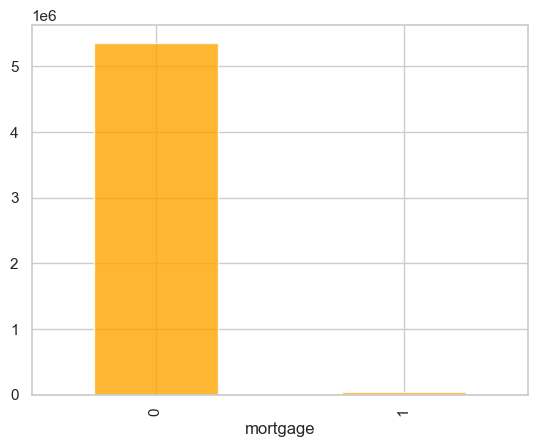

In [69]:
data_Mortgage.groupby('mortgage')['cust_code'].count().plot(kind = 'bar',color='orange',alpha=0.8);

## Data Processing: Oversampling 

Because our dataset is too big and our computer memory cannot support us to run the whole dataset so we only use 0.3% to do the model prediction and tune hypermeters in model selection.

In [70]:
Mortgage_tain = Mortgage.sample(frac=0.003)

In [71]:
X = Mortgage_tain.iloc[:,:-1]

In [72]:
Y = Mortgage_tain.iloc[:,-1:]

In [73]:
X.columns = X.columns.astype(str)

We use the SMOTE packages to do the oversampling to avoid overfitting.

In [74]:
# Apply oversampling method
sm = SMOTE(random_state = 42)
X,Y = sm.fit_resample(X,Y)

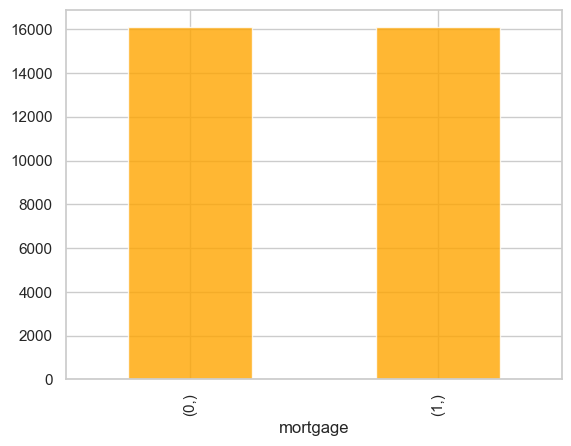

In [75]:
Y.value_counts().plot(kind = 'bar',color='orange',alpha=0.8);

In [76]:
for i in X.columns:
    X[i] = X[i].astype(int)

## Model Building

In [77]:
# Split data in training and test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Logistic Regression: Baseline Model

In [78]:
logmodel = LogisticRegression()
logmodel.fit(x_train,y_train)

/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [79]:
predictions = logmodel.predict(x_test)

In [80]:
LogAUC = logmodel.score(x_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(logmodel.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


In [81]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      3249
           1       0.75      0.85      0.80      3183

    accuracy                           0.78      6432
   macro avg       0.79      0.78      0.78      6432
weighted avg       0.79      0.78      0.78      6432



### Logistic Regression: Tunes hyperparameter

In [82]:
from sklearn.model_selection import GridSearchCV

In [83]:
# Define the hyperparameters to tune
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10],
    'solver': [ 'liblinear',  'saga']
}

In [84]:
# Create the LogisticRegression
lr = LogisticRegression()

# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(lr, param_grid=param_grid, cv=3)

# Fit the GridSearchCV object to the data
grid_search.fit(x_train, y_train)

/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/valid

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'saga']})

In [85]:
# Print the best hyperparameters and corresponding score
LogAUC_tune = grid_search.best_score_
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.9148721588848758


In [86]:
logreg_best = LogisticRegression(**grid_search.best_params_)
logreg_best.fit(x_train, y_train)

/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/utils/validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [87]:
predictions = logreg_best.predict(x_test)

In [88]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.88      0.92      3249
           1       0.89      0.96      0.92      3183

    accuracy                           0.92      6432
   macro avg       0.92      0.92      0.92      6432
weighted avg       0.92      0.92      0.92      6432



In [89]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(logreg_best.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.92


Aftre the GridSearchCV method, the hyperparameters {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} correspond to the Lasso regularization method is choosen in our logistic regression model. And it improves our AUC score from 0.8 to 0.9

### GradientBoosting

In [91]:
gdb = GradientBoostingClassifier(random_state=6)
gdb.fit(x_train,y_train)

/Users/xiangziying/opt/anaconda3/envs/JolinPython/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(random_state=6)

In [92]:
predictions = gdb.predict(x_test)

In [93]:
gdbAUC = gdb.score(x_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'
      .format(gdb.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [94]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3241
           1       0.91      0.99      0.95      3193

    accuracy                           0.95      6434
   macro avg       0.95      0.95      0.95      6434
weighted avg       0.95      0.95      0.95      6434



### XGBoost

In [95]:
xgb = xgb.XGBClassifier(objective='binary:logistic')

In [96]:
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
xgbAUC = accuracy_score(y_test, y_pred)

In [97]:
print("Accuracy: %.2f%%" % (xgbAUC * 100.0))

Accuracy: 98.48%


In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3241
           1       0.97      1.00      0.98      3193

    accuracy                           0.98      6434
   macro avg       0.98      0.98      0.98      6434
weighted avg       0.99      0.98      0.98      6434



### XGBoost: Tunes hyperparameter

In [99]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [100]:
# Define the hyperparameters to tune
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [101]:
# Initialize the XGB model
xgb = xgb.XGBClassifier(subsample=0.9,objective='binary:logistic')

In [102]:
# Use GridSearchCV to search for the best hyperparameters
grid_search= GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 3,
    verbose=True
)

In [103]:
model2 = grid_search.fit(x_train, y_train)
print("Best parameters:", model2.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 180}


In [104]:
predict1 = model2.predict(x_test)
xgbAUC_tune = accuracy_score(y_test, predict1)
print('Best AUC Score: {}'.format(model2.best_score_))
print('Accuracy: {}'.format(accuracy_score(y_test, predict1)))

Best AUC Score: 0.9988184310941555
Accuracy: 0.9872552067143301


## Model Comparison and Model Selection

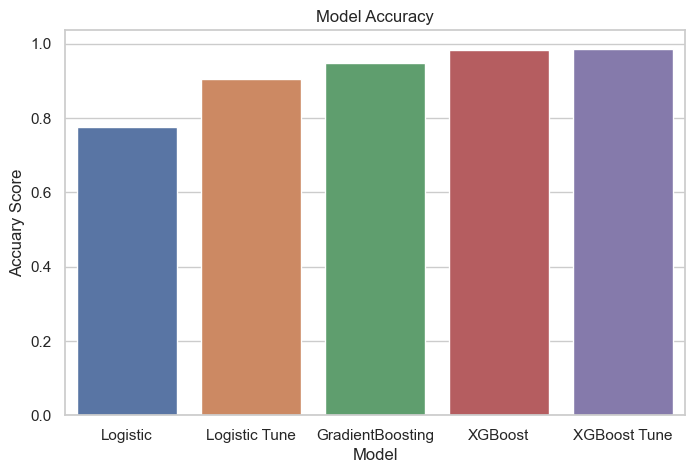

In [105]:
plt.figure(figsize=(8, 5))
x = ['Logistic', 'Logistic Tune', 'GradientBoosting','XGBoost','XGBoost Tune']
y = [LogAUC,LogAUC_tune,gdbAUC,xgbAUC,xgbAUC_tune ] 
sns.barplot(x = x, y = y)

plt.title('Model Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuary Score')
plt.show()

**Conclusion:**
* Even though after tuning hyperparameters, the Logistic Regression does not have the highest AUC score in thses five models, we will still choose logistic regression as our final model. Because when dealing with the over-sampled data, although there are overfitting problems in logistic regression, the risk of logistic regression model is relatively small compared with other models. And the regularization of Lasso logistic regression model can also control the overfitting problem effectively.
* The oversampling technique can increase the number of samples of a few categories in the dataset.  So it can improve the recognition ability of the model to a few categories and overall accuracy. However, the model relies too much on these repeated samples after oversampling method, resulting in a very good performance in training data, while Gradient Boosting and XGBoost have a big problem with overfitting.